In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Load the Excel file from the specified path
file_path = '/Users/brendankhow/Documents/SMU/Sem 4.1/FYP/Michelle Data/[Closed] SMU Strength in Mind and Body Roadshow 2025 - Survey Form(1-392).xlsx'
survey_data = pd.read_excel(file_path)

survey_data.head()

,ID,Start time,Completion time,Email,Name,Last modified time,Full Name:,SMU Email Address (Please ensure you have keyed in the correct SMU email address),I found the activity engaging,I will recommend this activity to others,I found the activity engaging2,I will recommend this activity to others2,"Please share with us key takeaways from ""Strength in mind and body"" roadshow","Please let us know how we can improve ""Strength in mind and body"" roadshow for the SMU community",Any other feedback or comments
0,1,2025-02-19 11:00:11,2025-02-19 11:01:35,anonymous,NaN,NaN,Koh Jia Xuan,jxkoh.2021@scis.smu.edu.sg,Agree,Neutral,Neutral,Neutral,Quotes get me through ;),More physical > online,Thank you for doing this up!
1,2,2025-02-19 11:02:00,2025-02-19 11:02:57,anonymous,NaN,NaN,Saachi baldwa,S.Baldwa.2025@exchange.smu.edu.sg,Agree,Agree,Neutral,Neutral,Importance of self care,Na,NaN
2,3,2025-02-19 11:02:12,2025-02-19 11:03:06,anonymous,NaN,NaN,Sanyukta phanse,Sanyuktas.p.2023@economics.Smu.edu.sg,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Inspiring,Nil,Nil
3,4,2025-02-19 11:01:51,2025-02-19 11:03:27,anonymous,NaN,NaN,Mariana Lopes,mariana.1.2024@exchange.smu.edu.sg,Agree,Agree,Strongly agree,Strongly agree,Strenght in mind and body are essential for we...,Further explanations of concepts,NaN
4,5,2025-02-19 11:02:24,2025-02-19 11:03:27,anonymous,NaN,NaN,Tuyubing,yubing.tu.2024@mm.smu.edu.sg,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Madia,Collaboration with social media companies,NaN


In [9]:
# Assuming survey_data is already loaded as a DataFrame

# Step 2: Remove unwanted columns by index (A, B, C, D, E, F, G → indexes 0 to 6)
cols_to_remove = survey_data.columns[[0, 1, 2, 3, 4, 5, 6]]
survey_data.drop(columns=cols_to_remove, inplace=True)

# Step 3: Define the original email column name (with non-breaking space)
email_col = 'SMU Email Address (Please ensure you have keyed in the correct SMU email address)\xa0'

# Step 4: Remove rows with Gmail addresses
survey_data = survey_data[~survey_data[email_col].str.contains('gmail.com', case=False, na=False)]

# Step 5: Assign student groups based on email
def assign_group(email):
    if pd.isna(email):
        return 'others'
    email = email.lower()
    if '@scis' in email or '@computing' in email:
        return 'school of computing'
    elif '@economics' in email:
        return 'school of economics'
    elif '@phd' in email:
        return 'post graduate'
    elif '@law' in email:
        return 'school of law'
    elif '@business' in email:
        return 'school of business'
    elif '@socsc' in email:
        return 'school of social sciences'
    elif '@exchange' in email:
        return 'exchange students'
    elif '@accountancy' in email:
        return 'school of accountancy'
    elif '@smu' in email or '@msa' in email or '@mm' in email:
        return 'others'
    else:
        return 'others'

survey_data['Student Group'] = survey_data[email_col].apply(assign_group)

# Step 6: Assign Student Level (UG/PG)
def assign_level(email):
    if pd.isna(email):
        return 'others'
    email = email.lower()
    if '@phd' in email:
        return 'PG'
    elif ('@scis' in email or '@computing' in email or
          '@economics' in email or '@law' in email or
          '@business' in email or '@socsc' in email or
          '@exchange' in email or '@accountancy' in email or
          '@smu' in email or '@msa' in email or '@mm' in email):
        return 'UG'
    else:
        return 'others'

survey_data['Student Level'] = survey_data[email_col].apply(assign_level)

# Step 7: Extract Year of Study
current_year = 2025
def extract_year_of_study(email):
    if pd.isna(email):
        return 'others'
    email = email.lower()
    match = re.search(r'\b(20[1-3][0-9])\b', email)
    if match:
        intake_year = int(match.group(1))
        year_of_study = 2026 - intake_year  # per your specification
        if 1 <= year_of_study <= 5:
            return f"Year {year_of_study}"
        else:
            return 'others'
    return 'others'

survey_data['Year of Study'] = survey_data[email_col].apply(extract_year_of_study)

# Step 8: Rename email column to 'SMU Email Address'
survey_data.rename(columns={email_col: 'SMU Email Address'}, inplace=True)

# Step 9: Place the new columns beside the email column
cols = list(survey_data.columns)
cols_to_move = ['Student Group', 'Student Level', 'Year of Study']
cols.remove('SMU Email Address')
for col_name in cols_to_move:
    if col_name in cols:
        cols.remove(col_name)
new_order = ['SMU Email Address'] + cols_to_move + cols
survey_data = survey_data[new_order]

# Step 10: Rename some columns for clarity
survey_data.rename(columns={
    'I found the activity engaging': 'Engagement Before',
    'I will recommend this activity to others': 'Recommend Before',
    'I found the activity engaging2': 'Engagement After',
    'I will recommend this activity to others2': 'Recommend After',
}, inplace=True)

# Step 11: Overwrite text columns as lowercase
text_cols = [
    'Please share with us key takeaways from "Strength in mind and body" roadshow',
    'Please let us know how we can improve "Strength in mind and body" roadshow for the SMU community',
    'Any other feedback or comments'
]

for col in text_cols:
    survey_data[col] = survey_data[col].str.lower()

# Step 11a: Clean "nil", "na", 'nill', "-", "none", "n/a" from the 3 text columns and replace with empty strings
def clean_placeholder(text):
    if isinstance(text, str):
        text_lower = text.strip().lower()
        if text_lower in ['n', 'nil', 'nill', 'na', '-', 'none', 'n/a']:
            return ''
        else:
            return text.strip()
    else:
        return ''

for col in text_cols:
    survey_data[col] = survey_data[col].apply(clean_placeholder)

# Step 12: Save cleaned and processed data to Excel file
output_file = '/Users/brendankhow/Documents/SMU/Sem 4.1/FYP/Michelle Data/Cleaned_Survey_Grouped.xlsx'
survey_data.to_excel(output_file, index=False)

print(f"Data cleaned and saved to {output_file}. Here's a preview:")
print(survey_data.head(15))

Data cleaned and saved to /Users/brendankhow/Documents/SMU/Sem 4.1/FYP/Michelle Data/Cleaned_Survey_Grouped.xlsx. Here's a preview:
                        SMU Email Address              Student Group  \
0              jxkoh.2021@scis.smu.edu.sg        school of computing   
1       S.Baldwa.2025@exchange.smu.edu.sg          exchange students   
2   Sanyuktas.p.2023@economics.Smu.edu.sg        school of economics   
3      mariana.1.2024@exchange.smu.edu.sg          exchange students   
4            yubing.tu.2024@mm.smu.edu.sg                     others   
5    ra.banerjee.2024@exchange.smu.edu.sg          exchange students   
6          huiqi.lim.2023@scis.smu.edu.sg        school of computing   
7        Jingyongchu.2023@scis.smu.edu.sg        school of computing   
8                 shermeenling@smu.edu.sg                     others   
9         gloria.yuen.2023@law.smu.edu.sg              school of law   
10          esthera.a.2023@law.smu.edu.sg              school of law   
11  

/var/folders/y3/gx893w4n6q12db36k2k5fsk00000gn/T/ipykernel_67258/758305151.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Student Group', order=df['Student Group'].value_counts().index, palette='Blues')


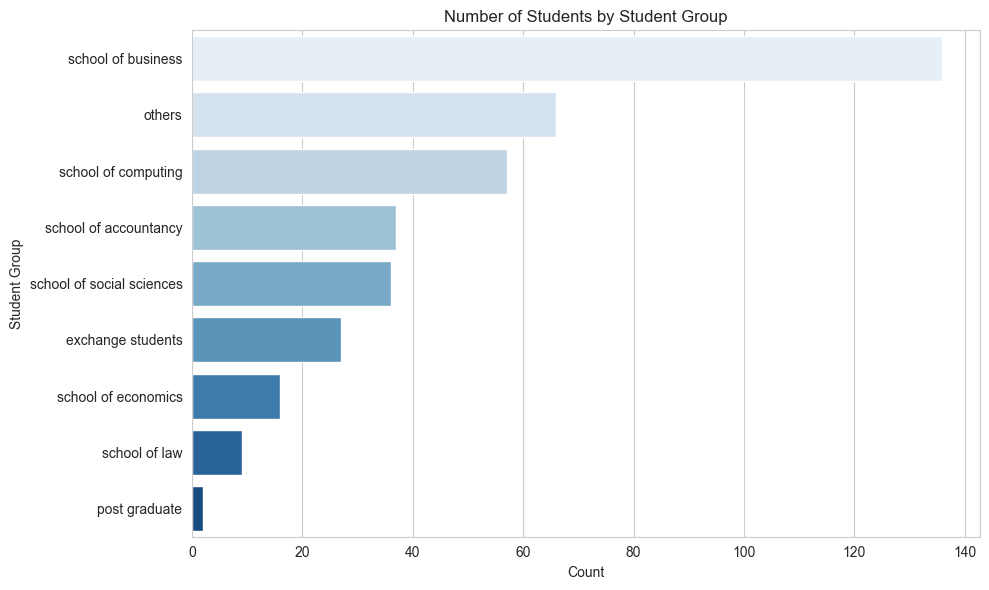

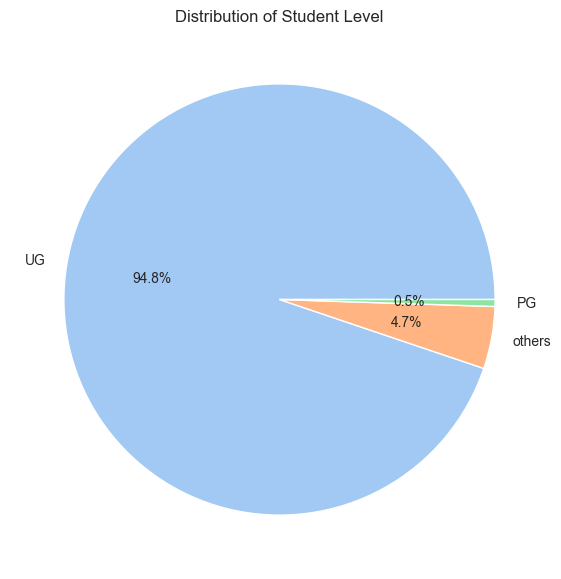

/var/folders/y3/gx893w4n6q12db36k2k5fsk00000gn/T/ipykernel_67258/758305151.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Year of Study', order=year_order, palette='Set2')


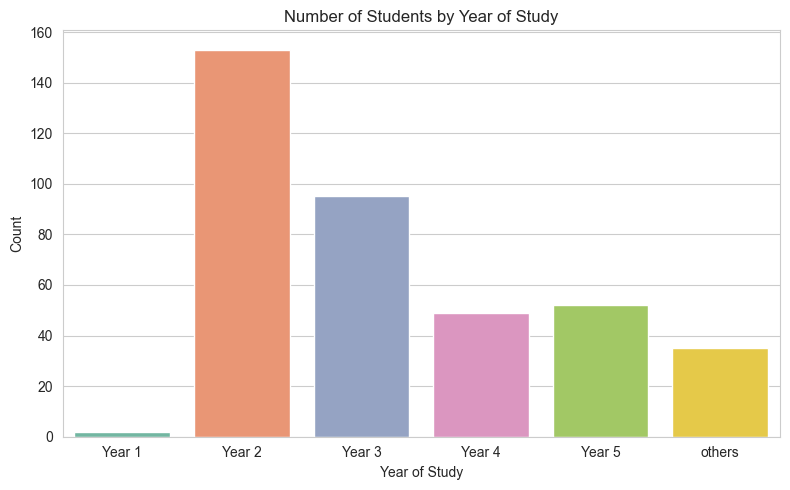

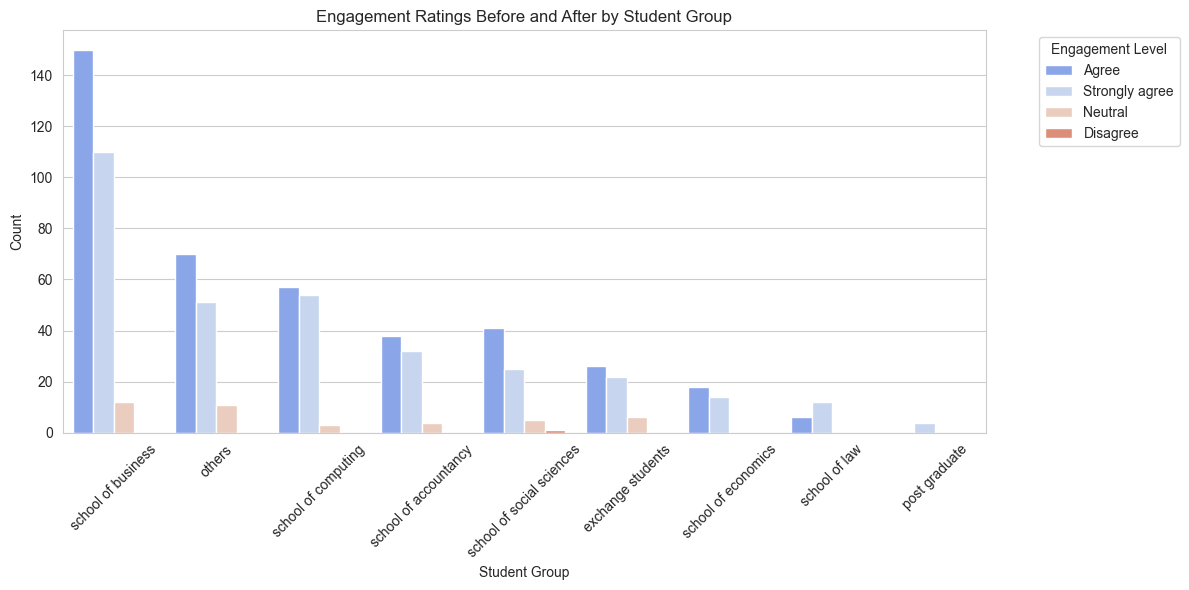

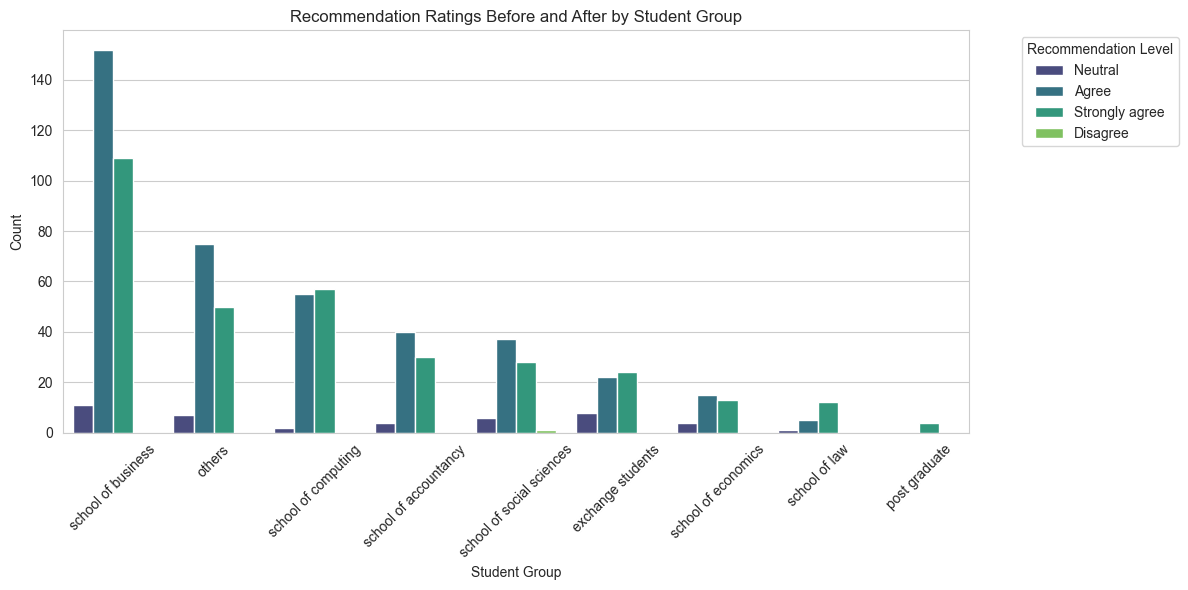

In [10]:
# Load the cleaned data from Excel
file_path = '/Users/brendankhow/Documents/SMU/Sem 4.1/FYP/Michelle Data/Cleaned_Survey_Grouped.xlsx'

df = pd.read_excel(file_path)

# Set plot style
sns.set_style('whitegrid')

# Chart 1: Number of Students by Student Group
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='Student Group', order=df['Student Group'].value_counts().index, palette='Blues')
plt.title('Number of Students by Student Group')
plt.xlabel('Count')
plt.ylabel('Student Group')
plt.tight_layout()
plt.show()

# Chart 2: Distribution of Student Level (Pie Chart)
plt.figure(figsize=(7,7))
level_counts = df['Student Level'].value_counts()
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Student Level')
plt.show()

# Chart 3: Count of Students by Year of Study
plt.figure(figsize=(8,5))
# Sort Year of Study logically with 'others' last
year_order = sorted(df['Year of Study'].unique(), key=lambda x: (x == 'others', x))
sns.countplot(data=df, x='Year of Study', order=year_order, palette='Set2')
plt.title('Number of Students by Year of Study')
plt.xlabel('Year of Study')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Chart 4: Engagement Before and After by Student Group (Clustered Bar)
engage_df = df.melt(id_vars=['Student Group'], value_vars=['Engagement Before', 'Engagement After'], var_name='Timing', value_name='Engagement')
plt.figure(figsize=(12,6))
sns.countplot(data=engage_df, x='Student Group', hue='Engagement', palette='coolwarm', order=df['Student Group'].value_counts().index)
plt.title('Engagement Ratings Before and After by Student Group')
plt.xlabel('Student Group')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Engagement Level', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

# Chart 5: Recommendation Before vs After by Student Group (Clustered Bar)
rec_df = df.melt(id_vars=['Student Group'], value_vars=['Recommend Before', 'Recommend After'], var_name='Timing', value_name='Recommendation')
plt.figure(figsize=(12,6))
sns.countplot(data=rec_df, x='Student Group', hue='Recommendation', palette='viridis', order=df['Student Group'].value_counts().index)
plt.title('Recommendation Ratings Before and After by Student Group')
plt.xlabel('Student Group')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Recommendation Level', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


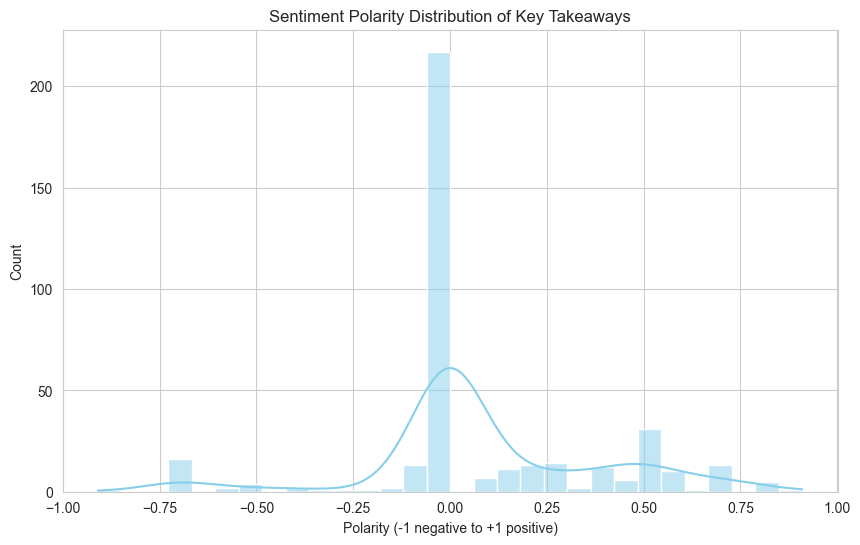

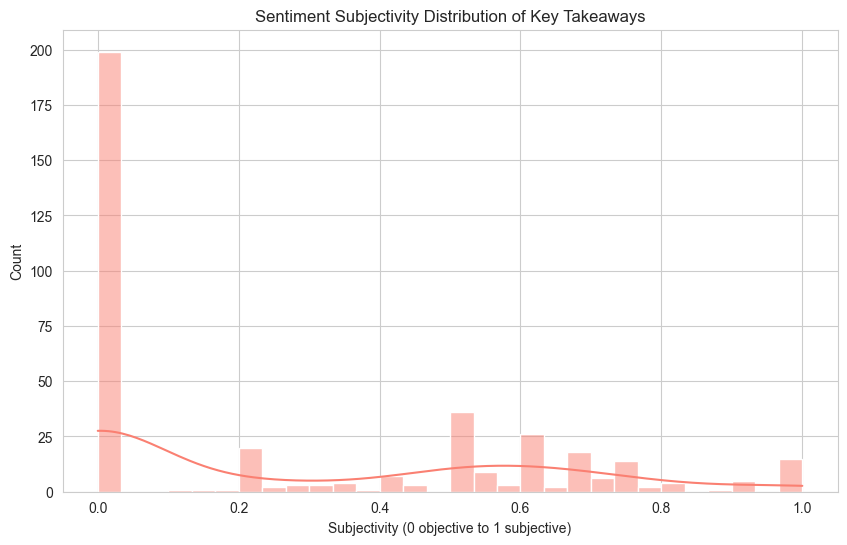

Theme 1:
good | vape | care | dont | positive | great | engaging | importance | smoking | friends

Theme 2:
body | mind | stay | strong | nice | learnt | key | wellness | strength | learn

Theme 3:
health | mental | help | fun | manage | physical | friends | mentally | resilient | need

Theme 4:
vaping | bad | important | resources | tips | healthy | know | harmful | learnt | cope

Theme 5:
resilience | stress | support | interesting | library | learning | ways | better | resources | healthy



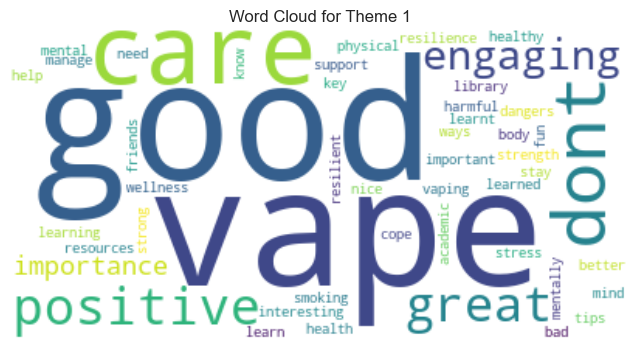

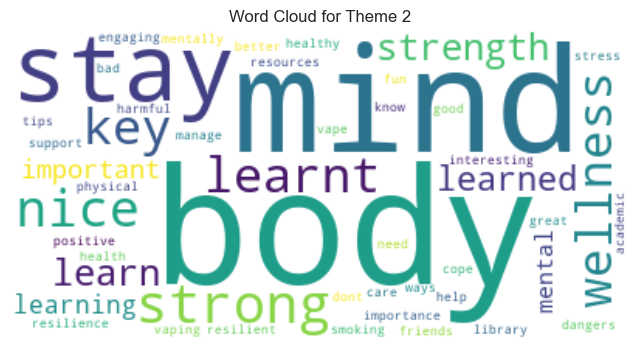

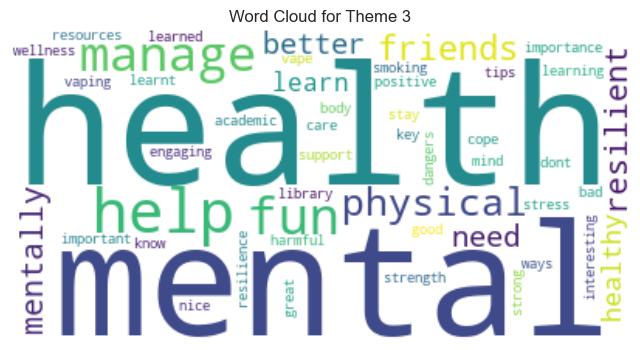

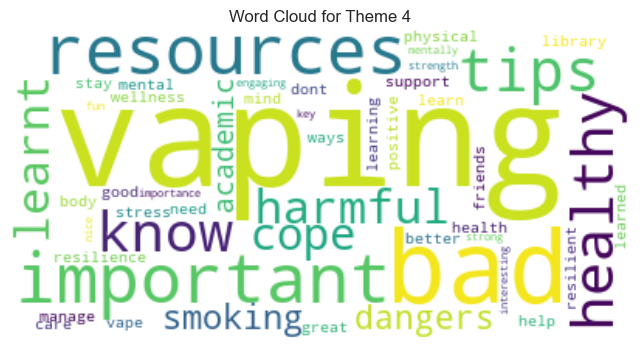

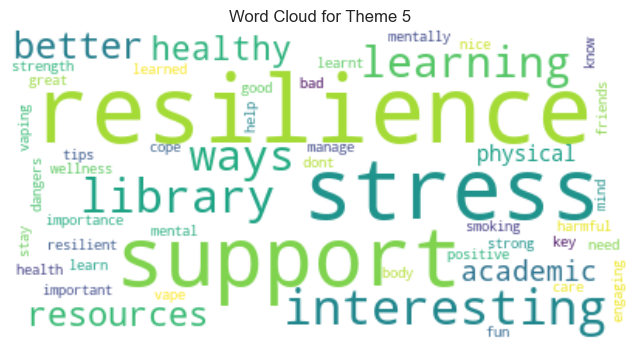

In [11]:
# # Load data
# file_path = 'Cleaned_Survey_Grouped.xlsx'
# df = pd.read_excel(file_path)

# Extract the qualitative text responses (key takeaways)
texts = df['Please share with us key takeaways from "Strength in mind and body" roadshow'].fillna('')

# Text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\n', ' ', text)  # remove new lines
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

clean_texts = texts.apply(clean_text)

# ----- Sentiment Analysis -----
# Compute polarity and subjectivity using TextBlob
df['sentiment_polarity'] = clean_texts.apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = clean_texts.apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Plot sentiment polarity distribution
plt.figure(figsize=(10,6))
sns.histplot(df['sentiment_polarity'], bins=30, kde=True, color='skyblue')
plt.title('Sentiment Polarity Distribution of Key Takeaways')
plt.xlabel('Polarity (-1 negative to +1 positive)')
plt.ylabel('Count')
plt.show()

# Plot sentiment subjectivity distribution
plt.figure(figsize=(10,6))
sns.histplot(df['sentiment_subjectivity'], bins=30, kde=True, color='salmon')
plt.title('Sentiment Subjectivity Distribution of Key Takeaways')
plt.xlabel('Subjectivity (0 objective to 1 subjective)')
plt.ylabel('Count')
plt.show()


# ----- Thematic Coding with Topic Modeling (LDA) -----
# Vectorize text corpus using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(clean_texts)

# Fit LDA model
n_topics = 5  # Number of themes to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Function to display top words per topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Theme {topic_idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

# Optional: Generate word clouds for each theme
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(8,6))
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Theme {topic_idx + 1}')
    plt.show()


In [12]:
# Columns to analyze
improve_col = 'Please let us know how we can improve "Strength in mind and body" roadshow for the SMU community'
feedback_col = 'Any other feedback or comments'

# Clean text function reused
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Process each column separately
for col in [improve_col, feedback_col]:
    print(f"\nAnalysis for column: {col}\n{'-'*40}")
    texts = df[col].fillna('').apply(clean_text)
    
    # Sentiment Analysis
    df[f'{col}_polarity'] = texts.apply(lambda x: TextBlob(x).sentiment.polarity)
    df[f'{col}_subjectivity'] = texts.apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Print polarity summary
    print(f"Sentiment polarity summary for {col}:")
    print(df[f'{col}_polarity'].describe())
    
    # Topic Modeling
    vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)
    
    def display_topics(model, feature_names, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Theme {topic_idx + 1}:")
            print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
            print()
    
    print("Top words per theme:")
    display_topics(lda, vectorizer.get_feature_names_out(), no_top_words=10)



Analysis for column: Please let us know how we can improve "Strength in mind and body" roadshow for the SMU community
----------------------------------------
Sentiment polarity summary for Please let us know how we can improve "Strength in mind and body" roadshow for the SMU community:
count    386.000000
mean       0.156364
std        0.259471
min       -0.250000
25%        0.000000
50%        0.000000
75%        0.445833
max        1.000000
Name: Please let us know how we can improve "Strength in mind and body" roadshow for the SMU community_polarity, dtype: float64
Top words per theme:
Theme 1:
activities | interactive | think | maybe | booths | great | nil | good | yes

Theme 2:
nil | great | activities | good | think | booths | interactive | maybe | yes

Theme 3:
good | think | nil | activities | interactive | booths | great | maybe | yes

Theme 4:
yes | think | good | interactive | booths | great | activities | maybe | nil

Theme 5:
maybe | booths | activities | think | great |

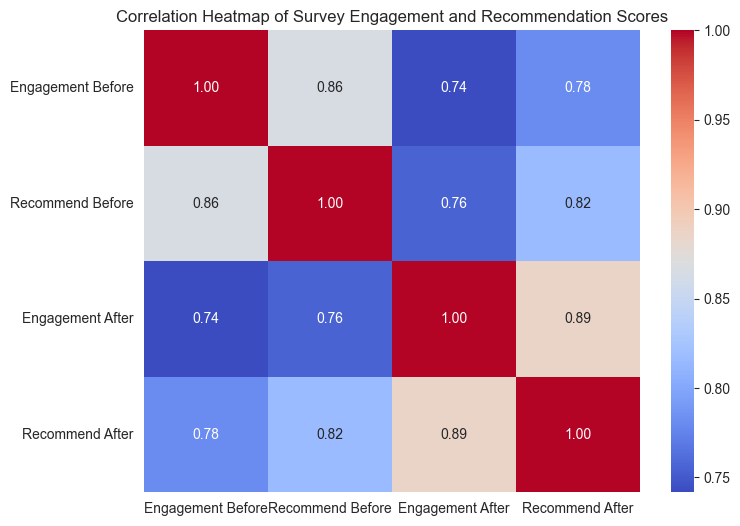

In [14]:
# Load the survey Excel file
survey_df = pd.read_excel('/Users/brendankhow/Documents/SMU/Sem 4.1/FYP/Michelle Data/Cleaned_Survey_Grouped.xlsx')

# Mapping agreement categories to numeric scores
agree_map = {
    'Strongly disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly agree': 5
}

# Convert categorical columns to numeric for correlation analysis
survey_df['Engagement Before Num'] = survey_df['Engagement Before'].map(agree_map)
survey_df['Recommend Before Num'] = survey_df['Recommend Before'].map(agree_map)
survey_df['Engagement After Num'] = survey_df['Engagement After'].map(agree_map)
survey_df['Recommend After Num'] = survey_df['Recommend After'].map(agree_map)

# Select relevant numeric columns
numeric_cols = ['Engagement Before Num', 'Recommend Before Num', 'Engagement After Num', 'Recommend After Num']

# Calculate correlation matrix
corr_matrix = survey_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=['Engagement Before', 'Recommend Before', 'Engagement After', 'Recommend After'],
            yticklabels=['Engagement Before', 'Recommend Before', 'Engagement After', 'Recommend After'])
plt.title('Correlation Heatmap of Survey Engagement and Recommendation Scores')
plt.show()
